In [15]:
from importlib import reload  
import numpy as np
import matplotlib.pyplot as plt
import pycraf
import cysgp4
import astropy.coordinates as coord
from pycraf import conversions as cnv
from pycraf import protection, antenna, geometry,satellite
from astropy import units as u, constants as const
import glob
from scepter import skynet,obs,tlefinder
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz, ICRS
from matplotlib.gridspec import GridSpec
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [16]:

###reload here
reload(skynet)
reload(obs)
longitude = coord.Angle("11d55m08s").deg
latitude = coord.Angle("+57d23m20s").deg
elevation = 16 * u.m
loc1 = EarthLocation(longitude, latitude, elevation)
ant1=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)

# baseline=75 *u.m### m
longitude = coord.Angle("11d55m11s").deg
latitude = coord.Angle("+57d23m37s").deg
elevation = 16 * u.m
ant2=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)
loc2 = EarthLocation(longitude, latitude, elevation)

longitude = coord.Angle("11d55m15s").deg
latitude = coord.Angle("+57d23m20s").deg
elevation = 16 * u.m
ant3=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)
loc3 = EarthLocation(longitude, latitude, elevation)

observers = np.array([ant1,ant2,ant3])



In [17]:
bearings,baselines,rabs,itermask = obs.baseline_pairs(observers)


print(rabs,itermask)

###load the TLEs

[49.939004820247774, 116.52451519089242, 66.5768414982018] [(0, 1), (0, 2), (1, 2)]


In [18]:
bearing_ab,great_circle,baseline= obs.baseline_bearing(ant1,ant2)
baseline=baseline*u.m
rab=baseline*np.sin(bearing_ab)
print("bearing_ab",bearing_ab)
print("rab",rab)
print("baseline",baseline)


bearing_ab 3.0467719152105666
rab 49.939004820247774 m
baseline 527.4575753687502 m


In [31]:
niters = 1
pydt = cysgp4.PyDateTime() ## take current date and time
start_times_window = 24 * u.hour
time_range, time_resol = 300*u.s, 1*u.s  # seconds
epochiters=time_range/time_resol

# print(start_times,td)
mjds = skynet.plantime(niters,start_times_window,time_range,time_resol,pydt)
print(mjds.shape)

(1, 1, 1, 1, 300, 1)


In [32]:
###load some tle from starlink
import requests
url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
ctrak_starlink = requests.get(url).text

tle_list = cysgp4.tle_tuples_from_text(ctrak_starlink)

In [33]:
tles = np.array([
    cysgp4.PyTle(*tle) for tle in tle_list
    ])[:500]  # use which TLEs

print (f'we are simulating {tles.shape[0]} satellites over {niters*start_times_window.to_value(u.day)} days,')
print(f'each day/epoch contains {epochiters} integrations over {time_range} seconds')
print(tles.shape)

we are simulating 500 satellites over 1.0 days,
each day/epoch contains 300.0 integrations over 300.0 s seconds
(500,)


In [39]:
min_elevation = -30 * u.deg
grid_size = 3. * u.deg
npoints=1 ##pointing per cell
skygrid = skynet.pointgen(niters=npoints,
    step_size=grid_size,
    lat_range=(min_elevation, 90 * u.deg),
    rnd_seed=0,
    )

tel_az, tel_el, grid_info = skygrid 
print(tel_az.shape)


tx=obs.transmitter_info(p_tx_carrier=-44 * cnv.dBm, carrier_bandwidth=250*u.MHz, duty_cycle=100 * u.percent, d_tx=1*u.m,freq=10.95*u.GHz)
p_tx=tx.power_tx(10.7*u.GHz)
print(p_tx)


(1, 3438)
-27.68556230986828 dB(mW)


In [40]:
dish=13.2*u.m
eta=0.7 *100*u.percent ## in percentage
### frequency band
## transmitter parameters
sat_antenna=0.1*u.m
### observatory list will be passed on internally like this

rx=obs.receiver_info(dish,eta,observers,freq=10.7*u.GHz,bandwidth=2*u.GHz)

1.2589254117941673 W / (Hz m2)


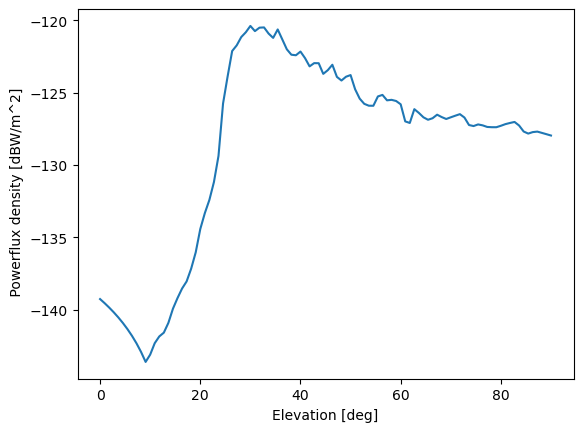

In [41]:
el_response=pd.read_csv('starlink_statistical_pfd.csv')
x_el=el_response['el'].values
y_spfd=el_response['psd_dBW_m2_4khz'].values  ### spectral powerflux density

scale4khz=50e6/4e3 ###4kHz to 1 Hz 
print((1*cnv.dB_W_m2_Hz).to(u.W/u.m**2/u.Hz))
###powerflux_nu = powerflux / bandwidth

y_pfd=(y_spfd*cnv.dB_W_m2_Hz).to(u.W/u.m**2/u.Hz)*(scale4khz*u.Hz) ### powerflux density I think in dB units it's this log factor, maybe should change this methiod
y_pfd=y_pfd.to(cnv.dB_W_m2)
plt.plot(x_el,y_pfd)
plt.ylabel(' Powerflux density [dBW/m^2]')
plt.xlabel('Elevation [deg]')
plt.show()

In [42]:
test=obs.obs_sim(tx,rx,skygrid,mjds)
print(rx.location)
print("array order is observer, pointing per grid, skygrid cells, epochs, time samples per epoch, number of satellites")
print(test.tel_az.shape)

[<PyObserver: 11.9189d, 57.3889d, 0.0160km>
 <PyObserver: 11.9197d, 57.3936d, 0.0160km>
 <PyObserver: 11.9208d, 57.3889d, 0.0160km>]
array order is observer, pointing per grid, skygrid cells, epochs, time samples per epoch, number of satellites
(1, 1, 3438, 1, 1, 1)


In [43]:
## if first time run the populate function to create coordinates
# test.populate(tles,save=True,savename='starlink_500')  

test.load_propagation(nparray='starlink_500.npz')
print(test.satf_az.shape)
print(test.satf_el.shape)
print(test.tel_az.shape)

(3, 1, 1, 1, 1, 1) (1, 1, 1, 1, 1, 500) (1, 1, 1, 1, 300, 1)
Obtaining satellite and time information, propagation for large arrays may take a while...
Done. Satellite coordinates obtained
(3, 1, 1, 1, 300, 500)
(3, 1, 1, 1, 300, 500)
(1, 1, 3438, 1, 1, 1)


(500,)
(array([ 35, 112, 312, 348, 367, 449]),)
ideal ra dec pointing for intercept 36.611297661414504 12.767198356355948


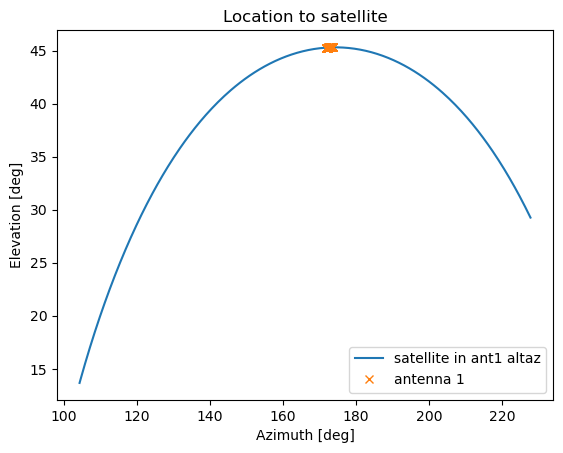

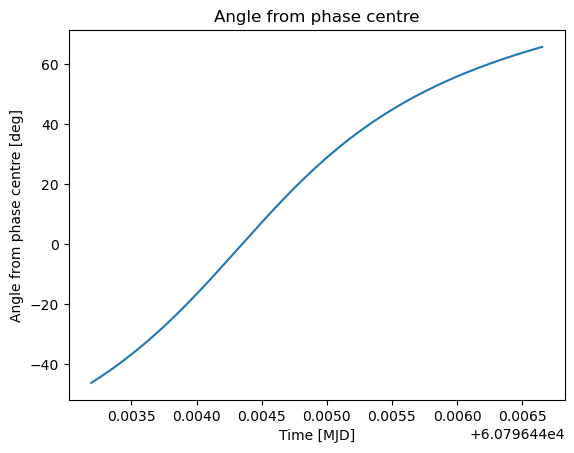

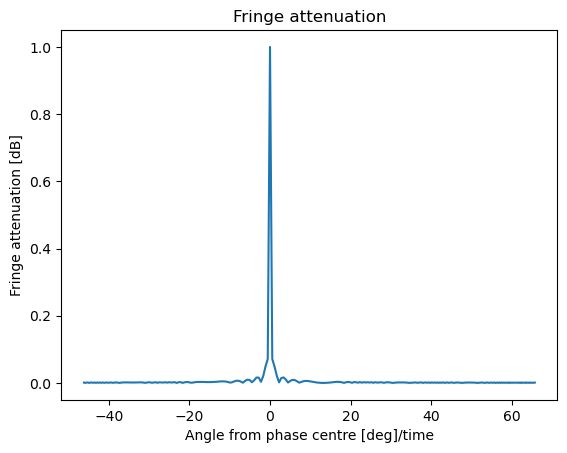

In [69]:
### get one satellite


mean_el=np.mean(test.topo_pos_el,axis=(0,1,2,3,4))
print(mean_el.shape)
mask=mean_el>20
print(np.where(mask))

nsat=np.where(mask)[0][0] ## get the first satellite above 20 degrees

satA_dist=test.satf_dist[:,:,:,:,:,nsat].reshape(len(observers),-1)
time = Time(mjds.flatten(), format='mjd')

#### setting up the altaz frame for the antennas
#### also get the 1-d arrays of the satellite location in altaz frame
tel_az1=test.topo_pos_az[0,:,:,:,:,nsat].flatten()
tel_el1=test.topo_pos_el[0,:,:,:,:,nsat].flatten()
altaz1 = AltAz( obstime=time, location=loc1)

tel_az2=test.topo_pos_az[1,:,:,:,:,nsat].flatten()
tel_el2=test.topo_pos_el[1,:,:,:,:,nsat].flatten()
altaz2 = AltAz(obstime=time, location=loc2)

tel_az3=test.topo_pos_az[2,:,:,:,:,nsat].flatten() 
tel_el3=test.topo_pos_el[2,:,:,:,:,nsat].flatten()
altaz3 = AltAz( obstime=time, location=loc3)
### create astropy skycoord objects
tel1_sats=SkyCoord(tel_az1,tel_el1, unit=(u.deg, u.deg),frame=altaz1)
tel2_sats=SkyCoord(tel_az2,tel_el2, unit=(u.deg, u.deg),frame=altaz2)
tel3_sats=SkyCoord(tel_az3,tel_el3, unit=(u.deg, u.deg),frame=altaz3)

plt.plot(tel_az1,tel_el1,label='satellite in ant1 altaz')
plt.xlabel('Azimuth [deg]')
plt.ylabel('Elevation [deg]')
plt.title('Location to satellite')







pnt=tel1_sats[100]
ra = pnt.icrs.ra.deg
dec = pnt.icrs.dec.deg
print('ideal ra dec pointing for intercept',ra,dec)
# ra=40
# dec=0
skycoord_track=SkyCoord(ra,dec, unit=u.deg,frame='icrs')
tel1_pnt=skycoord_track.transform_to(altaz1) ### get the altaz coordinates of the telescope pointing
# print(tel1_pnt.shape)
# tel2_pnt=skycoord_track.transform_to(altaz2)
plt.plot(tel1_pnt.az, tel1_pnt.alt,'x',label='antenna 1')
# plt.plot(tel2_pnt.az, tel2_pnt.alt,'x',label='antenna 1')

plt.legend()
plt.show()
plt.close()
offbeam=tel1_pnt.separation(tel1_sats)
offbeam[:np.argmin(offbeam)]*=-1
plt.plot(mjds.flatten(),offbeam)
plt.xlabel('Time [MJD]')
plt.ylabel('Angle from phase centre [deg]')
plt.title('Angle from phase centre')
plt.show()
fringe_attenuation=obs.fringe_attenuation(baseline=rab,theta=offbeam,bandwidth=2000*u.MHz)
plt.plot(offbeam, (np.abs(fringe_attenuation)))
plt.xlabel('Angle from phase centre [deg]/time')
plt.ylabel('Fringe attenuation [dB]')
plt.title('Fringe attenuation')
plt.show()

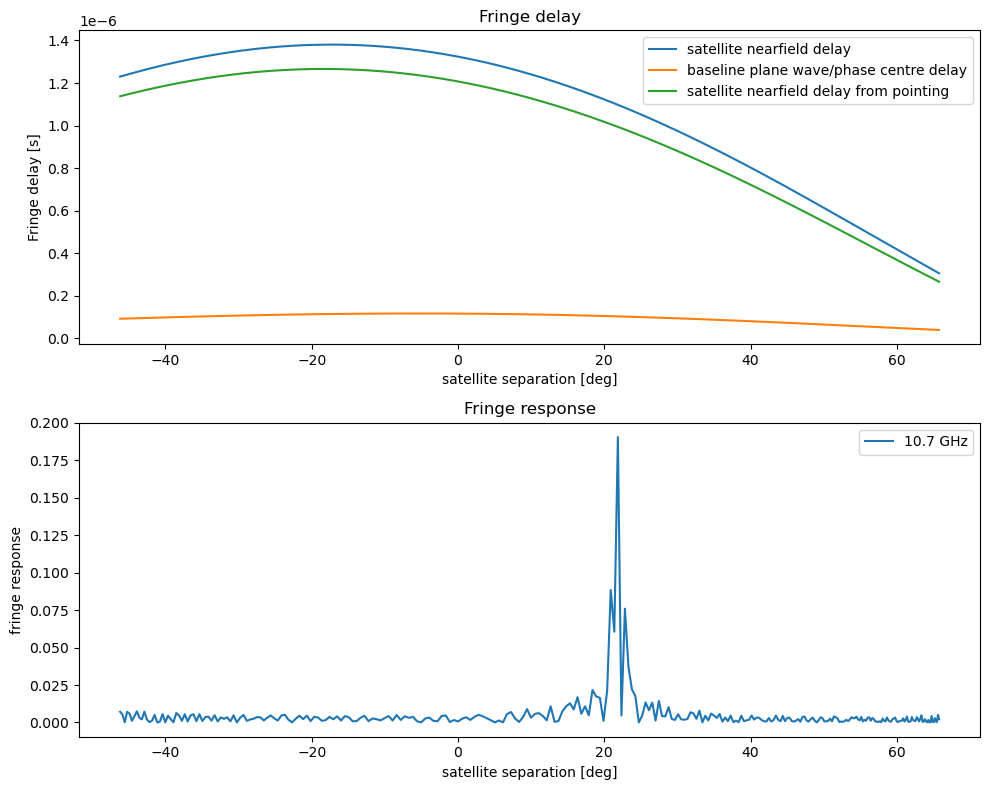

In [71]:
ew_alt=obs.ew_elevation(tel1_pnt.alt, tel1_sats.az)
real_delays=obs.baseline_nearfield_delay(theta=ew_alt,l1=satA_dist[0]*u.km,l2=satA_dist[1]*u.km,baseline=rab)
plt.figure(figsize=(10, 8))
ax1=plt.subplot(211)
ax1.plot(offbeam, real_delays,label='satellite nearfield delay')
ax1.plot(offbeam,obs.tdelay(rab,ew_alt),label='baseline plane wave/phase centre delay')
ax1.plot(offbeam, real_delays-obs.tdelay(rab,ew_alt),label='satellite nearfield delay from pointing')

ax1.set_xlabel('satellite separation [deg]')
ax1.set_ylabel('Fringe delay [s]')
ax1.set_title('Fringe delay')
# ax1.set_xlim(-40,40)
ax1.legend()

# bwfringe = np.sum([obs.fringe_response(delay=real_delays-obs.tdelay(rab,tel2_pnt.alt),frequency=i*u\.Hz) for i in np.arange(10.7e9,10.95e9,1e6)],axis=0)
ax2=plt.subplot(212)
bwfringe=obs.bw_fringe(delays=obs.tdelay(rab,ew_alt)-real_delays,bwchan=250,nchan=250,fch1=10.7e3)
# bwfringe=obs.fringe_response(delay =real_delays-obs.tdelay(rab,ew_alt),frequency=1000*u.MHz)

ax2.plot(offbeam, (np.abs(bwfringe)),label=f'{10.7} GHz')
# for fch1 in np.arange(10.7e3,12.0e3,250):
    # bwfringe=obs.bw_fringe(delays=real_delays-obs.tdelay(rab,ew_alt),bwchan=250,nchan=250,fch1=fch1)
    # ax2.plot(offbeam, (np.abs(bwfringe)/250),label=f'{fch1/1e3:.2f} GHz')
ax2.set_xlabel('satellite separation [deg]')

ax2.set_ylabel('fringe response')
ax2.set_title('Fringe response')
ax2.legend()
plt.tight_layout()
plt.show()

In [29]:
star_el=test.topo_pos_el
print(star_el.shape)
### get power from satellite
satpwrpfd=(np.interp(star_el,xp=x_el,fp=y_pfd))  ###

(3, 1, 1, 1, 100, 500)


In [30]:
### calculate the satellite delay time for all antennas
